# Imports & Configuration

In [1]:
import SimpleITK as sitk
import numpy as np
import glob
import os
import tifffile
import matplotlib.pyplot as plt
from IPython.display import clear_output
import config


DATA_BASE_PATH = os.path.join(config.DATASPACE, "TMA_Cores_Grouped_NEW")
WORK_OUTPUT= os.path.join(config.DATASPACE, "Registered")
TARGET_CORE = "Core_11" 

INPUT_FOLDER = os.path.join(DATA_BASE_PATH, TARGET_CORE)
OUTPUT_FOLDER =  os.path.join(WORK_OUTPUT, "test")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Get sorted file list
file_list = sorted(glob.glob(os.path.join(INPUT_FOLDER, "*.ome.tif")))
print(f"Target: {TARGET_CORE} | Found {len(file_list)} slices")
print(f"Output: {WORK_OUTPUT} ")



Target: Core_11 | Found 20 slices
Output: /data3/junming/3D-TMA-Register/Registered 


# VISUALIZATION HELPER

In [2]:
def show_live_check(fixed, moving, slice_num, direction):
    clear_output(wait=True)
    
    # 1. Downsample (8x)
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    # 2. ROBUST NORMALIZATION 
    # Instead of dividing by max(), we divide by the 99th percentile.
    # This ignores the super-bright outliers and brightens the tissue.
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1 # Avoid division by zero
        return np.clip(x / p99, 0, 1) # Scale and clip everything above p99 to 1.0
    
    f_norm = robust_norm(f)
    m_norm = robust_norm(m)
    
    # 3. Create Composite
    # Fixed = Red, Moving = Green
    rgb = np.dstack((f_norm, m_norm, np.zeros_like(f_norm)))
    
    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(rgb)
    plt.title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned, Red/Green=Shifted)")
    plt.axis('off')
    plt.show()

#  Helper Function

In [3]:
import time 

def register_slice_with_metrics(fixed_full_image, moving_full_image):
    """
    EVOLUTIONARY STRATEGY + TIMER
    Returns: (Image, Metrics, Runtime_Seconds)
    """
    
    # A. CAST TO FLOAT32
    fixed_ck = sitk.Cast(fixed_full_image[:, :, 6], sitk.sitkFloat32)
    moving_ck = sitk.Cast(moving_full_image[:, :, 6], sitk.sitkFloat32)
    
    # B. INITIALIZATION (MOMENTS)
    initial_tx = sitk.CenteredTransformInitializer(
        fixed_ck, moving_ck, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    
    # C. SETUP REGISTRATION
    reg = sitk.ImageRegistrationMethod()
    
    # Robust Pyramid
    reg.SetShrinkFactorsPerLevel([8, 4, 2])
    reg.SetSmoothingSigmasPerLevel([2, 1, 0])
    reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
    
    # Metric: Mattes MI
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.20)
    
    # Optimizer: Evolutionary
    reg.SetOptimizerAsOnePlusOneEvolutionary(
        numberOfIterations=300, 
        epsilon=1e-6,           
        initialRadius=1.5,      
        growthFactor=1.1,       
        shrinkFactor=0.9        
    )
    
    reg.SetInitialTransform(initial_tx)
    
    # Tracking
    metric_values = []
    def on_iteration():
        metric_values.append(reg.GetMetricValue())
    reg.AddCommand(sitk.sitkIterationEvent, on_iteration)
    
    # D. EXECUTE (WITH TIMER)
    start_time = time.time() # <--- Start Clock
    try:
        final_tx = reg.Execute(fixed_ck, moving_ck)
    except Exception as e:
        print(f"  Warning: {e}")
        return moving_full_image, [], 0.0 # Return 0 time on fail
    end_time = time.time() # <--- Stop Clock
    
    execution_time = end_time - start_time
    
    # E. APPLY (Back to UInt16)
    rotated_channels = []
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_ck)
    resampler.SetTransform(final_tx)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    
    for c in range(8):
        chan = moving_full_image[:, :, c]
        aligned_chan = resampler.Execute(chan)
        rotated_channels.append(aligned_chan)
        
    aligned_full_image = sitk.JoinSeries(rotated_channels)
    aligned_full_image = sitk.Cast(aligned_full_image, sitk.sitkUInt16)
    
    return aligned_full_image, metric_values, execution_time # <--- Return Time

In [4]:
# --- DASHBOARD VISUALIZATION ---
def show_dashboard(fixed, moving, metrics, slice_num, direction, runtime):
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- LEFT: IMAGE ---
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1
        return np.clip(x / p99, 0, 1)
    
    rgb = np.dstack((robust_norm(f), robust_norm(m), np.zeros_like(f)))
    ax1.imshow(rgb)
    ax1.set_title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned)")
    ax1.axis('off')
    
    # --- RIGHT: PLOT ---
    if metrics:
        ax2.plot(metrics, color='blue', linewidth=2)
        ax2.set_title(f"Evolutionary Trace ({runtime:.2f} sec)") 
        ax2.set_xlabel("Iteration Step")
        ax2.set_ylabel("Mutual Information (Lower is Better)")
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        final_val = metrics[-1]
        ax2.plot(len(metrics)-1, final_val, 'ro')
        ax2.text(len(metrics)-1, final_val, f" {final_val:.3f}", color='red', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "Registration Failed", ha='center')
    
    plt.tight_layout()
    plt.show()

# Main Loop

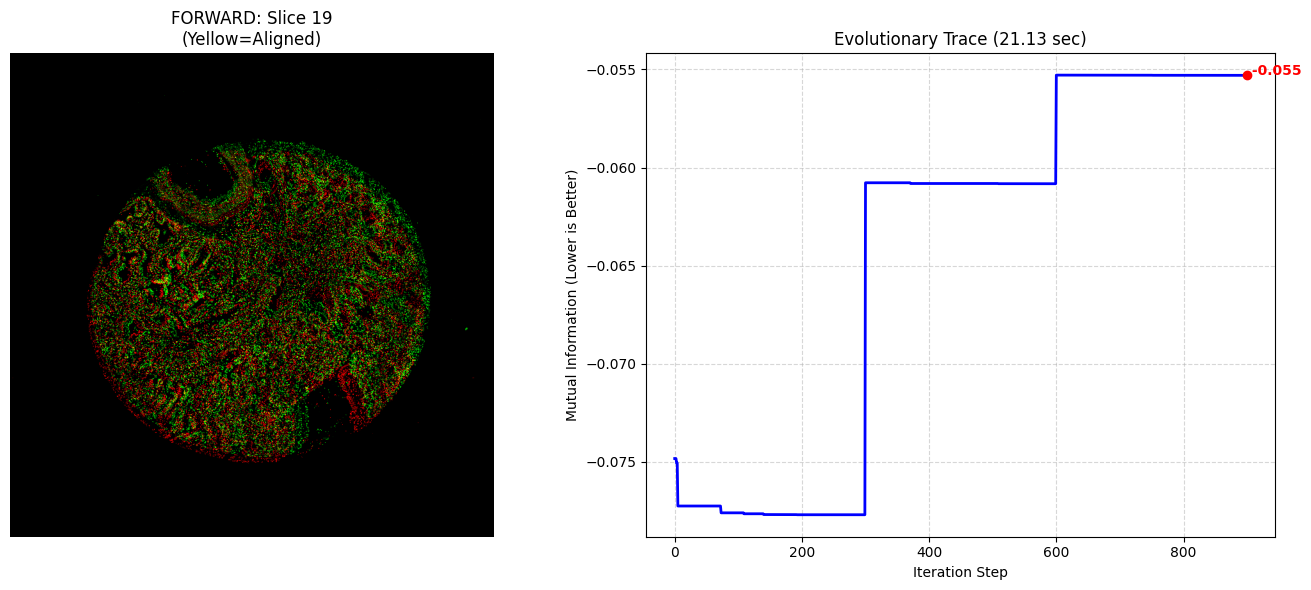

In [5]:

total_slices = len(file_list)
aligned_results = [None] * total_slices
registration_stats = [] 

# Anchor
center_idx = total_slices // 2
center_full = sitk.ReadImage(file_list[center_idx])
aligned_results[center_idx] = center_full
print(f"--- Anchor: Slice {center_idx} ---")

# BACKWARD
print("\n>>> BACKWARD")
current_fixed = center_full
for i in range(center_idx - 1, -1, -1):
    moving = sitk.ReadImage(file_list[i])
    
    # Get Time here
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Backward",
        "Moving_Slice": i,
        "Fixed_Ref": i + 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2)
    })
    
    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "BACKWARD", runtime)
    
    current_fixed = aligned

# FORWARD
print("\n>>> FORWARD")
current_fixed = center_full
for i in range(center_idx + 1, total_slices):
    moving = sitk.ReadImage(file_list[i])
    
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Forward",
        "Moving_Slice": i,
        "Fixed_Ref": i - 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2) 
    })

    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "FORWARD", runtime)
    
    current_fixed = aligned

# Evaluate

In [6]:
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
# Create DataFrame
df = pd.DataFrame(registration_stats)

# Reorder columns
df = df[["Direction", "Moving_Slice", "Fixed_Ref", "Final_Metric", "Iterations", "Runtime(s)"]]

# Sort by Slice Number
df = df.sort_values(by="Moving_Slice")

print("--- REGISTRATION QUALITY & PERFORMANCE REPORT ---")
try:
    display(df) 
except:
    print(df.to_string(index=False))


--- REGISTRATION QUALITY & PERFORMANCE REPORT ---


,Direction,Moving_Slice,Fixed_Ref,Final_Metric,Iterations,Runtime(s)
9,Backward,0,1,-0.053818,900,21.27
8,Backward,1,2,-0.092050,900,21.03
7,Backward,2,3,-0.049646,900,21.28
6,Backward,3,4,-0.051590,900,21.07
5,Backward,4,5,-0.054292,900,20.69
4,Backward,5,6,-0.047814,900,20.72
3,Backward,6,7,-0.058764,900,21.07
2,Backward,7,8,-0.044755,900,21.03
1,Backward,8,9,-0.052276,900,21.35
0,Backward,9,10,-0.055390,900,21.27


# Save Result

In [7]:
output_path = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CenterOut_Aligned_CK.ome.tif")
print(f"Saving to {output_path}...")

# Filter out any 'None' values just in case
valid_slices = [img for img in aligned_results if img is not None]

# Convert ITK (X,Y,8) -> Numpy (Z, 8, Y, X)
# GetArrayFromImage returns (8, Y, X). Stacking gives (Z, 8, Y, X).
vol = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"Final Volume Shape: {vol.shape}")

tifffile.imwrite(
    output_path, 
    vol, 
    photometric='minisblack',
    metadata={'axes': 'ZCYX'}
)
print("Done.")

Saving to /data3/junming/3D-TMA-Register/Registered/test/Core_11_CenterOut_Aligned_CK.ome.tif...
Final Volume Shape: (20, 8, 6048, 6048)
Done.


In [8]:
import tifffile
import os
import numpy as np


print("SAVING REGISTERED VOLUME FOR FIJI")

# Define output path
output_tiff = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CenterOut_Aligned_CK.ome.tif")

print(f"\n Output file: {output_tiff}")

# Convert aligned results to volume
valid_slices = [img for img in aligned_results if img is not None]
vol = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"\n Volume Dimensions:")
print(f"   Shape: {vol.shape}")
print(f"   Z-slices: {vol.shape[0]}")
print(f"   Channels: {vol.shape[1]}")
print(f"   Height: {vol.shape[2]} pixels")
print(f"   Width: {vol.shape[3]} pixels")
print(f"   Total size: {vol.nbytes / 1e9:.2f} GB in memory")

# Channel metadata for FIJI
channel_names = ['DAPI', 'CD31', 'GAP43', 'NFP', 'CD3', 'CD163', 'CK', 'AF']

# Save as OME-TIFF with proper metadata for FIJI
print(f"\n Saving OME-TIFF...")

tifffile.imwrite(
    output_tiff, 
    vol,
    photometric='minisblack',
    metadata={
        'axes': 'ZCYX',
        'Channel': {'Name': channel_names[:vol.shape[1]]},
    },
    compression='zlib'  # Compress to reduce file size
)

file_size_mb = os.path.getsize(output_tiff) / 1e6

print(f" SAVED SUCCESSFULLY!")
print(f"   File: {os.path.basename(output_tiff)}")
print(f"   Size: {file_size_mb:.1f} MB")


SAVING REGISTERED VOLUME FOR FIJI

 Output file: /data3/junming/3D-TMA-Register/Registered/test/Core_11_CenterOut_Aligned_CK.ome.tif

 Volume Dimensions:
   Shape: (20, 8, 6048, 6048)
   Z-slices: 20
   Channels: 8
   Height: 6048 pixels
   Width: 6048 pixels
   Total size: 11.71 GB in memory

 Saving OME-TIFF...
 SAVED SUCCESSFULLY!
   File: Core_11_CenterOut_Aligned_CK.ome.tif
   Size: 1644.0 MB


# Quality Check Previews

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

print("CHECKING ALL CONSECUTIVE Z-SLICE PAIRS")


# Correct channel names
channel_names = ['DAPI', 'CD31', 'GAP43', 'NFP', 'CD3', 'CD163', 'CK', 'AF']

# Which channel to check (0=DAPI is usually best for registration)
check_channel = 0

print(f"\nUsing {channel_names[check_channel]} channel for quality check")
print(f"Total Z-slices: {vol.shape[0]}")
print(f"Number of consecutive pairs to check: {vol.shape[0] - 1}\n")

# Create all consecutive pairs
n_slices = vol.shape[0]
all_pairs = [(i, i+1) for i in range(n_slices - 1)]

print(f"Will check {len(all_pairs)} consecutive pairs:")
print(f"  {all_pairs}\n")


print("Displaying all pairs inline...\n")

# Calculate grid layout
n_pairs = len(all_pairs)
n_cols = min(4, n_pairs)  # Max 4 columns
n_rows = (n_pairs + n_cols - 1) // n_cols

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

# Make sure axes is always 2D array
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

axes_flat = axes.flatten()

for idx, (z1, z2) in enumerate(all_pairs):
    # Get slices
    slice1 = vol[z1, check_channel, :, :]
    slice2 = vol[z2, check_channel, :, :]
    
    # Normalize robustly
    def norm(x):
        p99 = np.percentile(x, 99.5)
        return np.clip(x / (p99 if p99 > 0 else 1), 0, 1)
    
    s1_norm = norm(slice1)
    s2_norm = norm(slice2)
    
    # Create overlay: RED=slice1, GREEN=slice2
    # YELLOW/WHITE = good overlap
    overlay = np.dstack((s1_norm, s2_norm, np.zeros_like(s1_norm)))
    
    # Display
    axes_flat[idx].imshow(overlay)
    axes_flat[idx].set_title(f'Z{z1} ↔ Z{z2}\n(Yellow=Aligned)', 
                            fontsize=11, fontweight='bold')
    axes_flat[idx].axis('off')

# Hide unused subplots
for idx in range(len(all_pairs), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.suptitle(f'ALL Consecutive Slice Pairs: {channel_names[check_channel]}\n' +
                f'Total pairs: {len(all_pairs)} | Yellow/White = Good Alignment | Red/Green = Misalignment',
                fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("All pairs displayed above")



CHECKING ALL CONSECUTIVE Z-SLICE PAIRS

Using DAPI channel for quality check
Total Z-slices: 20
Number of consecutive pairs to check: 19

Will check 19 consecutive pairs:
  [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19)]

Displaying all pairs inline...




----------------------------------------------------------------------
Creating compact montage of ALL pairs...
----------------------------------------------------------------------

✅ Saved compact montage: all_pairs_montage_DAPI.png


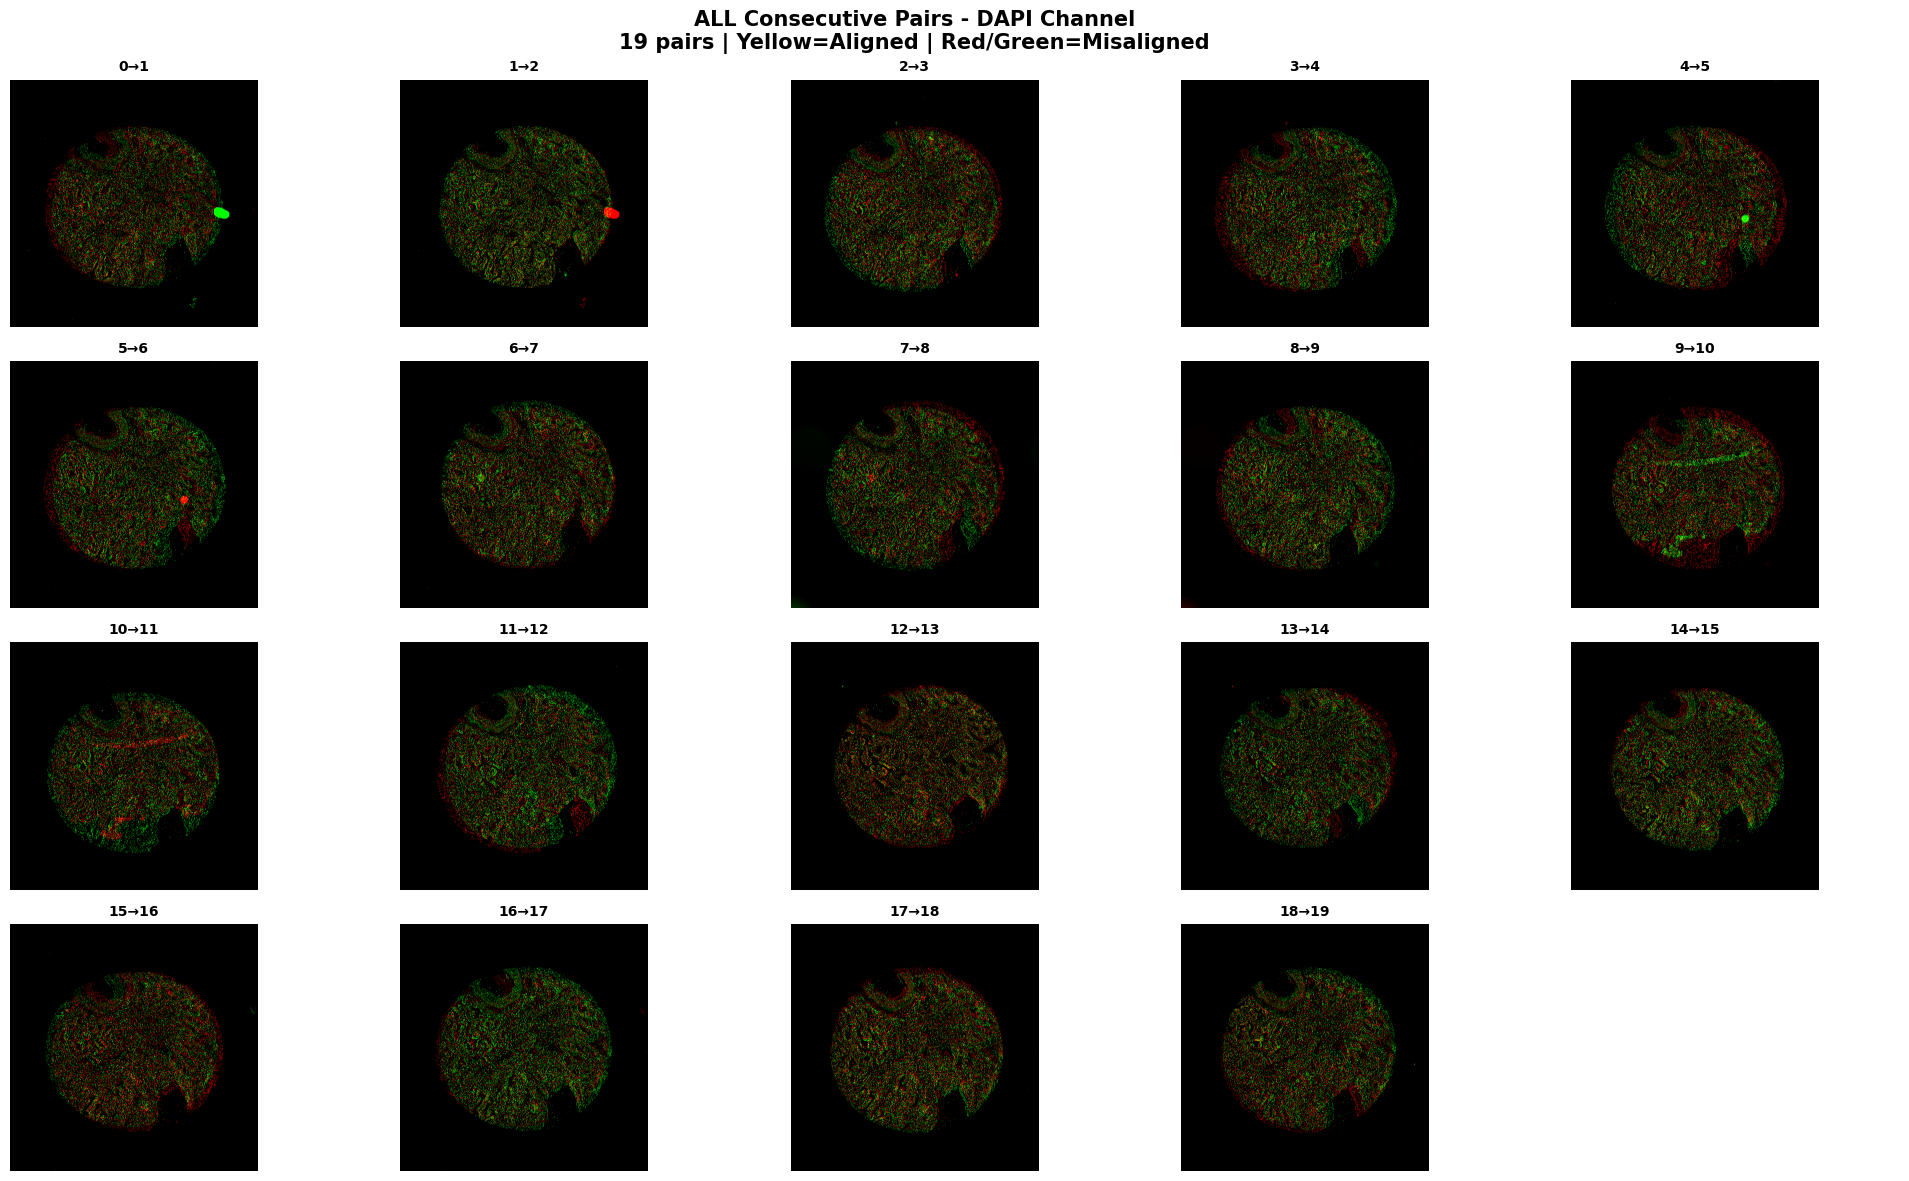

In [ ]:

print("Creating compact montage of ALL pairs...")


# Calculate grid for compact view
n_pairs = len(all_pairs)
n_cols = 5  # 5 pairs per row
n_rows = (n_pairs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

# Handle different axis configurations
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

axes_flat = axes.flatten()

for idx, (z1, z2) in enumerate(all_pairs):
    # Get slices
    slice1 = vol[z1, check_channel, :, :]
    slice2 = vol[z2, check_channel, :, :]
    
    # Normalize
    def norm(x):
        p99 = np.percentile(x, 99.5)
        return np.clip(x / (p99 if p99 > 0 else 1), 0, 1)
    
    s1_norm = norm(slice1)
    s2_norm = norm(slice2)
    
    # Overlay
    overlay = np.dstack((s1_norm, s2_norm, np.zeros_like(s1_norm)))
    
    axes_flat[idx].imshow(overlay)
    axes_flat[idx].set_title(f'{z1}→{z2}', fontsize=10, fontweight='bold')
    axes_flat[idx].axis('off')

# Hide unused subplots
for idx in range(len(all_pairs), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.suptitle(f'ALL Consecutive Pairs - {channel_names[check_channel]} Channel\n' +
             f'{n_pairs} pairs | Yellow=Aligned | Red/Green=Misaligned',
             fontsize=15, fontweight='bold')
plt.tight_layout()

# Save the montage
montage_path = os.path.join(OUTPUT_FOLDER, f"all_pairs_montage_{channel_names[check_channel]}.png")
plt.savefig(montage_path, dpi=200, bbox_inches='tight')
print(f"Saved compact montage: {os.path.basename(montage_path)}")

plt.show()


CHECK 3: Correlation scores between consecutive slices
   Higher score = better alignment



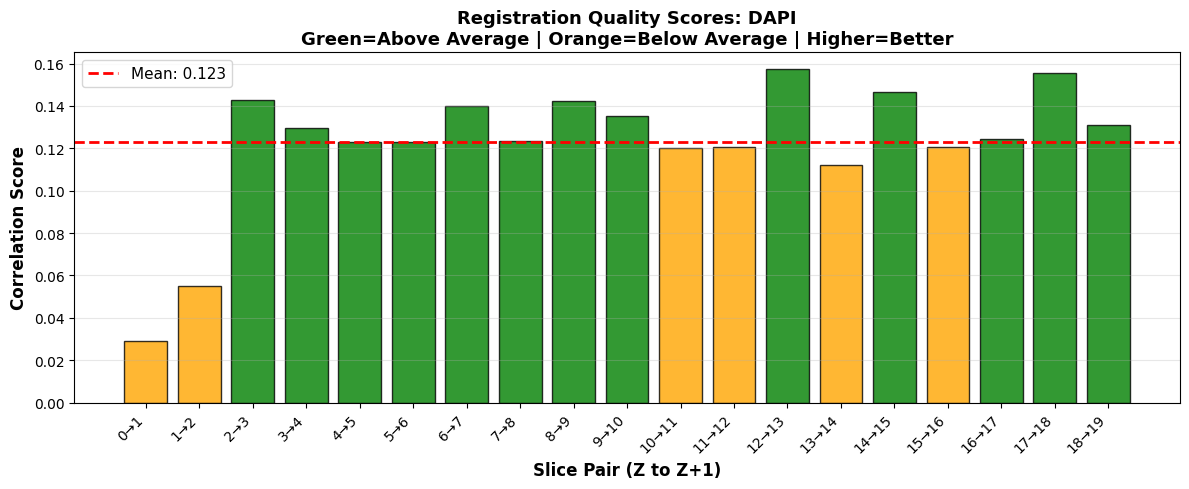

REGISTRATION QUALITY STATISTICS
Channel:          DAPI
Total slices:     20
Mean correlation: 0.1228
Std deviation:    0.0306
Min correlation:  0.0288 (slices 0→1)
Max correlation:  0.1575 (slices 12→13)

INTERPRETATION:
   POOR. Mean score 0.123 < 0.4
     Check registration parameters or problematic slices

 Slices with below-average alignment:
     Slices 0→1: score=0.029
     Slices 1→2: score=0.055

   You may want to visually inspect these specific pairs

 Quality check complete!


In [ ]:
print("\nCHECK Correlation scores between consecutive slices")
print("   Higher score = better alignment\n")

from scipy.signal import correlate2d

scores = []

for z in range(n_slices - 1):
    slice1 = vol[z, check_channel, :, :]
    slice2 = vol[z + 1, check_channel, :, :]
    
    # Normalize
    s1 = (slice1 - slice1.mean()) / (slice1.std() + 1e-10)
    s2 = (slice2 - slice2.mean()) / (slice2.std() + 1e-10)
    
    # Cross-correlation at zero lag
    corr = np.sum(s1 * s2) / s1.size
    scores.append(corr)

# Plot scores
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

colors = ['green' if s > np.mean(scores) else 'orange' for s in scores]
bars = ax.bar(range(len(scores)), scores, color=colors, alpha=0.8, edgecolor='black')

# Add mean line
ax.axhline(y=np.mean(scores), color='red', linestyle='--', linewidth=2, 
          label=f'Mean: {np.mean(scores):.3f}')

# Labels
ax.set_xlabel('Slice Pair (Z to Z+1)', fontsize=12, fontweight='bold')
ax.set_ylabel('Correlation Score', fontsize=12, fontweight='bold')
ax.set_title(f'Registration Quality Scores: {channel_names[check_channel]}\n' +
             'Green=Above Average | Orange=Below Average | Higher=Better',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11)

# Add slice pair labels
ax.set_xticks(range(len(scores)))
ax.set_xticklabels([f'{i}→{i+1}' for i in range(len(scores))], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print statistics

print("REGISTRATION QUALITY STATISTICS")

print(f"Channel:          {channel_names[check_channel]}")
print(f"Total slices:     {n_slices}")
print(f"Mean correlation: {np.mean(scores):.4f}")
print(f"Std deviation:    {np.std(scores):.4f}")
print(f"Min correlation:  {np.min(scores):.4f} (slices {np.argmin(scores)}→{np.argmin(scores)+1})")
print(f"Max correlation:  {np.max(scores):.4f} (slices {np.argmax(scores)}→{np.argmax(scores)+1})")

print(f"\nINTERPRETATION:")
mean_score = np.mean(scores)
if mean_score > 0.8:
    print(f"   EXCELLENT! Mean score {mean_score:.3f} > 0.8")
    print(f"     Registration worked very well!")
elif mean_score > 0.6:
    print(f"   GOOD! Mean score {mean_score:.3f} is 0.6-0.8")
    print(f"     Registration is acceptable for visualization")
elif mean_score > 0.4:
    print(f"    FAIR. Mean score {mean_score:.3f} is 0.4-0.6")
    print(f"     Some slices may have alignment issues")
else:
    print(f"   POOR. Mean score {mean_score:.3f} < 0.4")
    print(f"     Check registration parameters or problematic slices")

# Identify problem slices
if scores:
    threshold = np.mean(scores) - np.std(scores)
    problem_slices = [i for i, s in enumerate(scores) if s < threshold]
    
    if problem_slices:
        print(f"\n Slices with below-average alignment:")
        for idx in problem_slices:
            print(f"     Slices {idx}→{idx+1}: score={scores[idx]:.3f}")
        print(f"\n   You may want to visually inspect these specific pairs")

print("="*70)

print("\n Quality check complete!")



# Prepare Download Package

In [11]:
import tifffile
import numpy as np
import os

print("CREATING FIJI-FRIENDLY VERSION (Downsampled)")

# Convert aligned results to volume
valid_slices = [img for img in aligned_results if img is not None]
vol_full = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"\nOriginal volume dimensions:")
print(f"  Shape: {vol_full.shape}")
print(f"  Z-slices: {vol_full.shape[0]}")
print(f"  Channels: {vol_full.shape[1]}")
print(f"  Height × Width: {vol_full.shape[2]} × {vol_full.shape[3]}")
print(f"  Memory size: {vol_full.nbytes / 1e9:.2f} GB")

# Downsample by 2x in XY (keeps all slices and channels)
# This reduces file size by ~75% while keeping quality good
vol_downsampled = vol_full[:, :, ::2, ::2]

print(f"\n Downsampled (2x) dimensions:")
print(f"  Shape: {vol_downsampled.shape}")
print(f"  Memory size: {vol_downsampled.nbytes / 1e9:.2f} GB")
print(f"  Size reduction: {100 * (1 - vol_downsampled.nbytes / vol_full.nbytes):.1f}%")

# Save downsampled version
output_file = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CK_Downsampled2x_FIJI.ome.tif")

print(f"\n Saving file...")
print(f"   Output: {output_file}")

tifffile.imwrite(
    output_file,
    vol_downsampled,
    photometric='minisblack',
    metadata={
        'axes': 'ZCYX',
        'Channel': {
            'Name': ['DAPI', 'CD31', 'GAP43', 'NFP', 'CD3', 'CD163', 'CK', 'AF']
        }
    },
    compression='zlib'
)

file_size_mb = os.path.getsize(output_file) / 1e6

print(f"\n SUCCESS!")
print(f"   File: {os.path.basename(output_file)}")
print(f"   Size: {file_size_mb:.1f} MB")





CREATING FIJI-FRIENDLY VERSION (Downsampled)

Original volume dimensions:
  Shape: (20, 8, 6048, 6048)
  Z-slices: 20
  Channels: 8
  Height × Width: 6048 × 6048
  Memory size: 11.71 GB

 Downsampled (2x) dimensions:
  Shape: (20, 8, 3024, 3024)
  Memory size: 2.93 GB
  Size reduction: 75.0%

 Saving file...
   Output: /data3/junming/3D-TMA-Register/Registered/test/Core_11_CK_Downsampled2x_FIJI.ome.tif

 SUCCESS!
   File: Core_11_CK_Downsampled2x_FIJI.ome.tif
   Size: 435.3 MB
